## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [33]:
import os
import wandb
import numpy as np
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [34]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [35]:
celeba = torchvision.datasets.CelebA('celeba/Downloads/celeba/', target_type='attr', transform=transforms, download=False)
celeba_dataloader = torch.utils.data.DataLoader(celeba, 16, shuffle=True)

### отфильтруем ненужные атрибуты

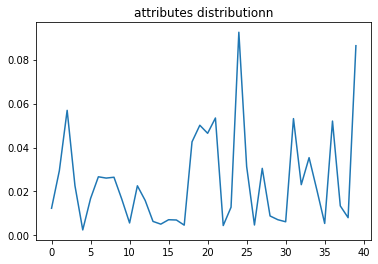

In [36]:
attr_hist = celeba.attr.sum(axis=0)
attr_hist = attr_hist / attr_hist.sum().float()

plt.title('attributes distributionn')

plt.plot(range(attr_hist.size(0)), attr_hist)
plt.show()

In [37]:
threshold = 0.02

np.array(celeba.attr_names)[np.nonzero(attr_hist > threshold)]

array([['Arched_Eyebrows'],
       ['Attractive'],
       ['Bags_Under_Eyes'],
       ['Big_Lips'],
       ['Big_Nose'],
       ['Black_Hair'],
       ['Brown_Hair'],
       ['Heavy_Makeup'],
       ['High_Cheekbones'],
       ['Male'],
       ['Mouth_Slightly_Open'],
       ['No_Beard'],
       ['Oval_Face'],
       ['Pointy_Nose'],
       ['Smiling'],
       ['Straight_Hair'],
       ['Wavy_Hair'],
       ['Wearing_Earrings'],
       ['Wearing_Lipstick'],
       ['Young']], dtype='<U19')

In [38]:
index2attr = {i:j for i, j in enumerate(celeba.attr_names)}
attr2index = {v:k for k, v in index2attr.items()}

assert attr2index[index2attr[6]] == 6

In [39]:
target_attrs = [
    'Young',
    'Male',
    'Smiling',
    'Straight_Hair',
    'Wavy_Hair',
    'Brown_Hair',
    'Black_Hair',
    'Blond_Hair',
    'Gray_Hair'
]


trg_idx2attr = {idx: att for idx, att in enumerate(target_attrs)}
trg_attr2idx = {att: idx for idx, att in enumerate(target_attrs)}

In [40]:
from utils import LabelTransformer

In [41]:
label_transformer = LabelTransformer(target_attrs, index2attr)

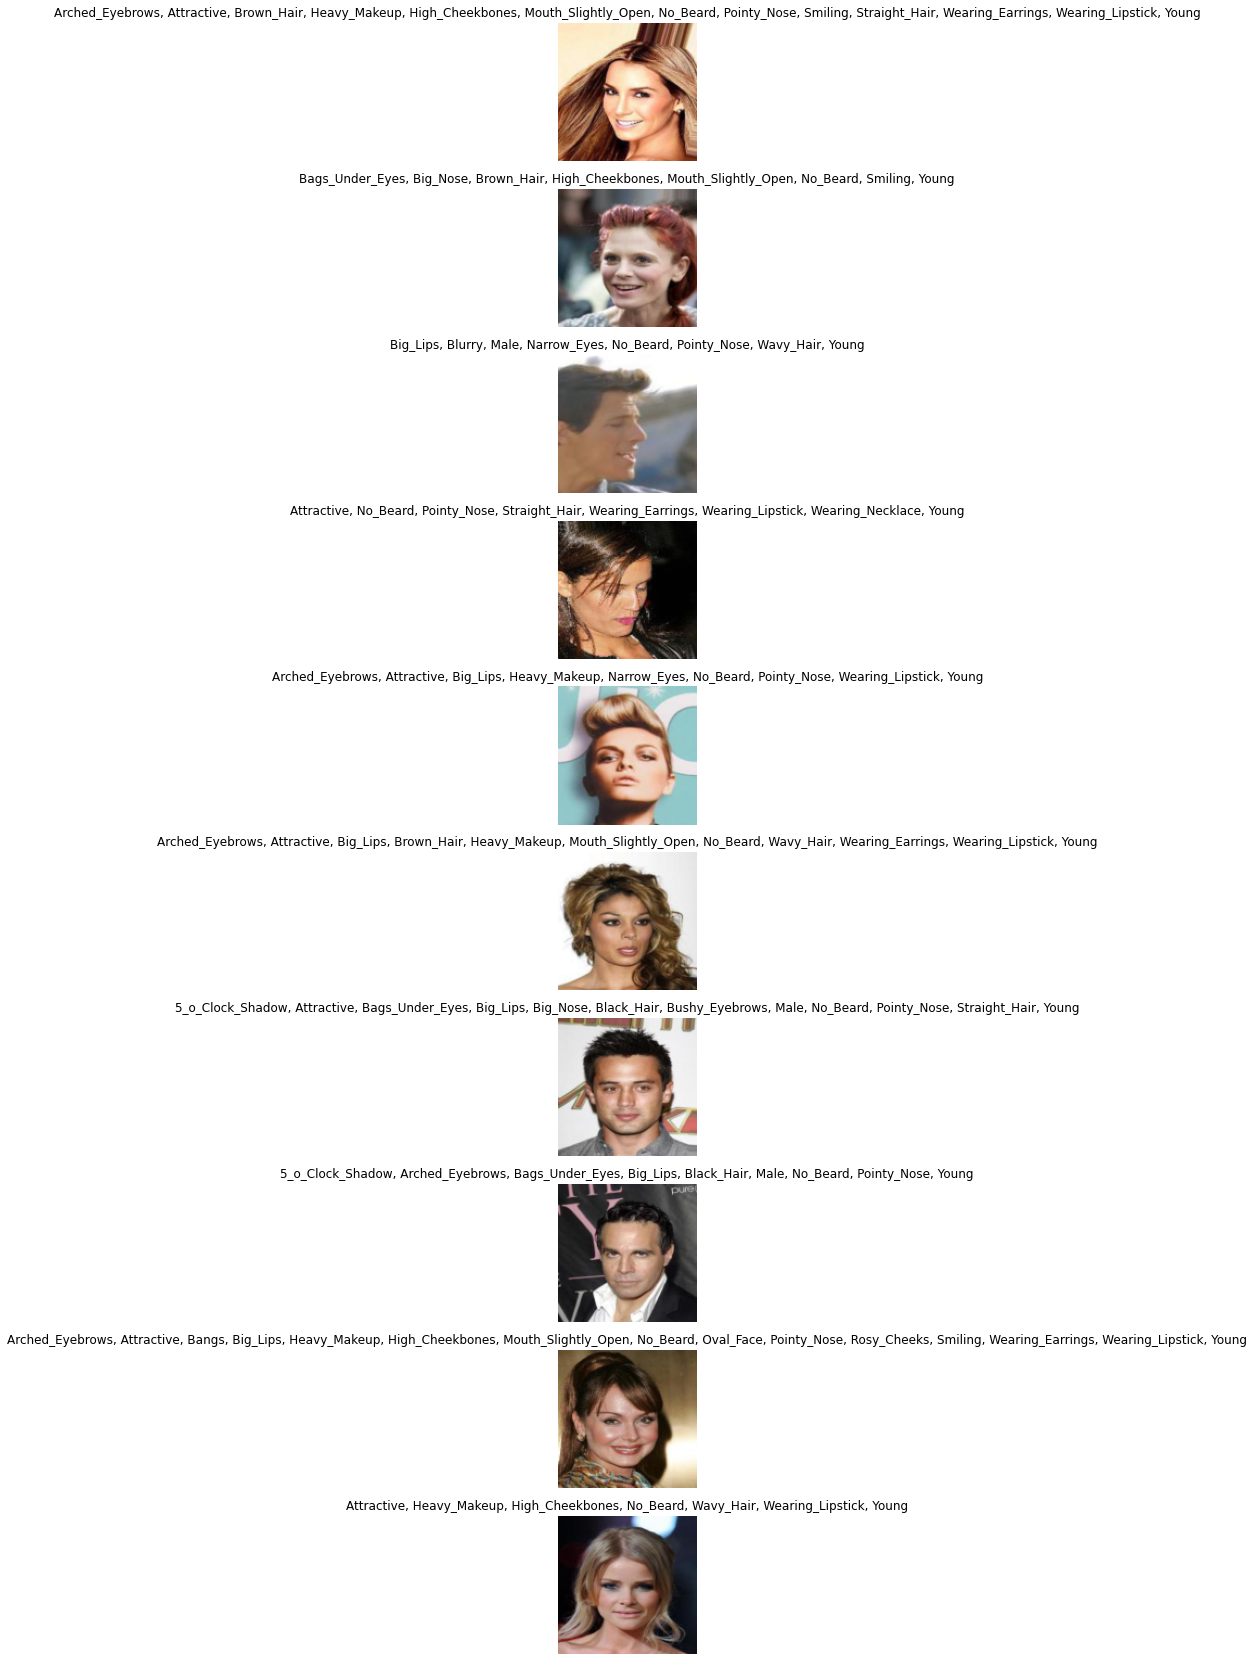

In [42]:
plt.figure(figsize=(30, 30))
for index, (image, attr) in enumerate(celeba):
    if index >= 10: break
    plt.subplot(10, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([index2attr[att_i] for att_i, att_val in enumerate(attr.view(-1)) if att_val == 1]))
    plt.axis('off')

plt.show()

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

###### test

In [11]:
import imp
import model, utils
imp.reload(model)
imp.reload(utils)

from utils import (
    permute_labels, 
    compute_gradient_penalty
)
from scipy import linalg

In [12]:
from model import StarGAN

model = StarGAN(
    input_features=3,
    lbl_features=label_transformer.label_dim,
    image_size=128
)

In [13]:
im = image.unsqueeze(0)
lbls = label_transformer.get_one_hot(attr).unsqueeze(0).type(torch.float32)

im_fake = model.forward_g(im, lbls).detach()

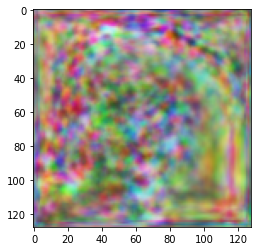

In [14]:
plt.imshow((im_fake.squeeze().permute(1, 2, 0) + 1) / 2)

In [26]:
def get_description(desc, epoch, d_cls, d_adv, d_gp, g_cls, g_adv, g_rec):
    return desc.format(epoch, g_cls, g_adv, g_rec, d_cls, d_adv, d_gp)


def train_epoch(train_loader, model, optimizers, epoch_num, config, log=False):
    model.train()
    iter_idx = 0
    
    optimizer_d = optimizers['D']
    optimizer_g = optimizers['G']
    
    losses = {
        "D": {
            'adversarial': [],
            'classification': [],
            'gp_loss': []
        },
        "G": {
            'adversarial': [],
            'reconstruction': [],
            'classification': []
        }
    }
    
    description = "Epoch: {}: Loss G: cls {:.4f}, adv {:.4f}, rec {:.4f};\n \
                    Loss D: cls {:.4f}, adv {:.4f}, gp {:.4f}"

    pbar = tqdm(train_loader, leave=False, desc=description.format(epoch_num, 0, 0, 0, 0, 0, 0), ncols=850)

    g_adv_loss = torch.tensor([1000])
    g_cls_loss = torch.tensor([1000])
    g_rec_loss = torch.tensor([1000])
    
    gp_loss = torch.tensor([0])
    
    for image, label in pbar:
        image = image.to(device)
        label = label.to(device)

        iter_idx += 1
        true_labels = label_transformer.get_one_hot(label).type(torch.float32)
        fake_labels = permute_labels(true_labels)


        image_fake = model.forward_g(image, fake_labels).detach()
        fake_patch_out, fake_cls_out = model.forward_d(image_fake)
        real_patch_out, real_cls_out = model.forward_d(image)
        
        d_loss_adv = - real_patch_out.mean() + fake_patch_out.mean()
        d_loss_cls = F.binary_cross_entropy_with_logits(real_cls_out, true_labels.clone())
        
        # gp_loss = compute_gradient_penalty(model.D, image, image_fake)

        d_loss = d_loss_adv + config['lambda_cls'] * d_loss_cls # + config['lambda_gp'] * gp_loss
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        
        losses['D']['adversarial'].append(d_loss_adv.item())
        losses['D']['gp_loss'].append(gp_loss.item())
        losses['D']['classification'].append(d_loss_cls.item())
        
        pbar.set_description(get_description(description, 
                                             epoch_num, 
                                             d_loss_cls.item(), 
                                             d_loss_adv.item(), 
                                             gp_loss.item(), 
                                             g_cls_loss.item(), 
                                             g_adv_loss.item(), 
                                             g_rec_loss.item()))
        

        if iter_idx % config['generator_step'] == 0:
            image_fake = model.forward_g(image, fake_labels)
            image_reconstructed = model.forward_g(image_fake, true_labels)

            g_rec_loss = torch.mean(torch.abs(image - image_reconstructed))
            fake_patch_out, cls_fake = model.forward_d(image_fake)

            g_cls_loss = F.binary_cross_entropy_with_logits(cls_fake, fake_labels.clone())
            g_adv_loss = -fake_patch_out.mean()
            
            optimizer_g.zero_grad()
            loss = g_adv_loss + config['lambda_cls'] * g_cls_loss + config['lambda_rec'] * g_rec_loss     
            loss.backward()
            optimizer_g.step()
            
            losses['G']['adversarial'].append(g_adv_loss.item())
            losses['G']['reconstruction'].append(g_rec_loss.item())
            losses['G']['classification'].append(g_cls_loss.item())
            
            pbar.set_description(get_description(description, 
                                                 epoch_num, 
                                                 d_loss_cls.item(), 
                                                 d_loss_adv.item(), 
                                                 gp_loss.item(), 
                                                 g_cls_loss.item(), 
                                                 g_adv_loss.item(), 
                                                 g_rec_loss.item()))
            
        if iter_idx % 100 == 0 and log:
            for type_m in losses:
                for loss_type in losses[type_m]:
                    wandb.log({
                        type_m + '/' + loss_type: np.mean(losses[type_m][loss_type][-100:])
                    })
    
    return losses


def fid_distance_from_activations(acts1, acts2):
    mu1 = np.mean(acts1, axis=0)
    sigma1 = np.cov(acts1, rowvar=False)
    
    mu2 = np.mean(acts2, axis=0)
    sigma2 = np.cov(acts2, rowvar=False)
    
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)
    

def interpolate_im(im_tensor):
    return F.interpolate(im_tensor, scale_factor=2, mode='bilinear', align_corners=False)
    

@torch.no_grad()
def validate(model_inc, model_gan, val_loader):
    device = next(model_inc.parameters()).device
    
    acts_real = np.zeros((len(val_loader.dataset), 1000))
    acts_fake = np.zeros((len(val_loader.dataset), 1000))

    for idx, (image, label) in tqdm(enumerate(val_loader), desc='Running evaluation...', leave=False):
        image = image.to(device)
        label = label.to(device)
        label = label_transformer.get_one_hot(label).type(torch.float32)
        fake = model_gan.generate(image, label)
        
        _acts_real = model_inc(interpolate_im(image)).detach().cpu().numpy()
        _acts_fake = model_inc(interpolate_im(fake)).detach().cpu().numpy()
        
        acts_real[idx * val_loader.batch_size: idx * val_loader.batch_size + image.size(0)] = _acts_real
        acts_fake[idx * val_loader.batch_size: idx * val_loader.batch_size + image.size(0)] = _acts_fake
        
    return fid_distance_from_activations(acts_real, acts_fake)
    
def save_checkpoit(model_gan, optimizers, epoch_num, path):
    checkpoint = {
        'epoch': epoch_num,
        'model_state_dict': model_gan.state_dict(),
        'optimizer_g_state_dict': optimizers['G'].state_dict(),
        'optimizer_d_state_dict': optimizers['D'].state_dict()
    }
    
    try:
        torch.save(checkpoint, path)
    except:
        print(f"Failed to save, epoch: {epoch_num}")
        
def load_checkpoint(path):
    checkpoint = torch.load(path)
    return checkpoint

------

In [16]:
image_size = 64


transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_size, image_size)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


celeba = torchvision.datasets.CelebA('celeba/Downloads/celeba/', 
                                     target_type='attr', 
                                     transform=transforms, 
                                     download=False)
train_size = int(len(celeba) * 0.7)
val_size = int(len(celeba) * 0.1)
test_size = len(celeba) - train_size - val_size

celeba_train, celeba_val, celeba_test = torch.utils.data.random_split(celeba, [train_size, val_size, test_size])

celeba_dataloader = torch.utils.data.DataLoader(celeba_train, 16, shuffle=True)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, 16, shuffle=True)

In [17]:
wandb.init(name="SpectralNorm_onlyD_night", project="StarGan", config={
    "Architecture": "StarGAN from paper",
    "batch_size": 16
})

wandb: Currently logged in as: vadim_titov (use `wandb login --relogin` to force relogin)


In [18]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [27]:
from model import StarGAN

model = StarGAN(
    input_features=3,
    lbl_features=label_transformer.label_dim,
    image_size=image_size
)

model.to(device)
model.train()

print("model loaded")

model loaded


In [20]:
inception_model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True).eval()
inception_model.to(device)

print('Succesfull!')

Using cache found in /home/vntitov/.cache/torch/hub/pytorch_vision_v0.6.0


Succesfull!


In [22]:
# ckpt = load_checkpoint('magic.pth')

In [23]:
# model.load_state_dict(ckpt['model_state_dict'])
# model.to(device)

# print('model_loaded')

model_loaded


In [28]:
config = {
    'lambda_gp': 10,
    'lambda_cls': 1,
    'lambda_rec': 10,
    'checkpoint_path': 'spectral_norm.pth',
    'generator_step': 5,
    'epochs': 15,
    'lr_d': 1e-4,
    'lr_g': 1e-4,
    'betas_g': [0.5, 0.999],
    'betas_d': [0.5, 0.999]
}

In [29]:
ckpt = None

In [30]:
optimizer_d = torch.optim.Adam(model.D.parameters(), lr=config['lr_d'], betas=config['betas_d'])
optimizer_g = torch.optim.Adam(model.G.parameters(), lr=config['lr_g'], betas=config['betas_g'])

# optimizer_d.load_state_dict(ckpt['optimizer_d_state_dict'])
# optimizer_g.load_state_dict(ckpt['optimizer_g_state_dict'])

optimizers = {
    'D': optimizer_d,
    'G': optimizer_g
}

k = config['lr_d'] / (config['epochs'] - 10)
print(f"k = {k}")
lambda_lr = lambda epoch: config['lr_d'] - k * (epoch - 10) if epoch > 9 else config['lr_d']

k = 2e-05


In [31]:
ckpt = None

In [ ]:
if ckpt is not None:
    start_epoch = ckpt['epoch']
else:
    start_epoch = 0


for epoch_num in range(start_epoch, config['epochs']):
    for model_T in optimizers:
        for g in optimizers[model_T].param_groups:
            g['lr'] = lambda_lr(epoch_num)
            
    losses = train_epoch(celeba_dataloader, model, optimizers, epoch_num + 1, config, log=True)
    save_checkpoit(model, optimizers, epoch_num, "spectral_norm.pth")
    fid = validate(inception_model, model, celeba_val_dataloader)
    
    wandb.log({"FID metric:": fid})
    wandb.log({'learning_rate': optimizer_d.param_groups[0]['lr']})
    
    print(f"Epoch: {epoch_num + 1}, FID value: {fid}")

Epoch: 1, FID value: 5761.469947212805


Epoch: 2, FID value: 5126.085461271947


Epoch: 3, FID value: 4750.675518490303


Epoch: 4, FID value: 3166.7326023964124


In [1]:
# checkpoint = load_checkpoint("night_learning.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'load_checkpoint' is not defined

In [86]:
celeba_test_dataloader = torch.utils.data.DataLoader(celeba_test, 10, shuffle=True)

model.eval()

orig_ims = []
fake_ims = []

for ind, (image, label) in enumerate(celeba_test_dataloader): # batch = 1
    label = label_transformer.get_one_hot(label).type(torch.float32)
    break
    if ind >= 10: break
#     label = label_transformer.get_one_hot(label).type(torch.float32)
#     # пример сравнения качества на глаз:
#     new_label = permute_labels(label)
#     plt.figure(figsize=(6, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow((image[0].permute(1, 2, 0) + 1) / 2)
#     orig_im = (image[0] + 1) / 2
#     orig_ims.append(orig_im)
    
#     plt.subplot(1, 2, 2)
#     fake_image = model.generate(image.to(device), label.to(device)).detach().cpu()[0]
#     fake_im = (fake_image + 1) / 2
#     fake_ims.append(fake_im)
    
#     plt.imshow((fake_image.permute(1, 2, 0) + 1) / 2)
#     plt.show()

In [93]:
generated_batches = [(image + 1) / 2]

for trg_attr in target_attrs:
    trg_idx = trg_attr2idx[trg_attr]
    
    old_column = label[:, trg_idx].clone()
    label[:, trg_idx] = 1.
    generated = (model.generate(image.to(device), label.to(device)).detach().cpu() + 1) / 2
    generated_batches.append(generated)
    
    label[:, trg_idx] = old_column

In [94]:
len(target_attrs)

9

In [95]:
torch.cat(generated_batches, dim=0).size()

torch.Size([100, 3, 64, 64])

In [96]:
grid_img = torchvision.utils.make_grid(torch.cat(generated_batches, dim=0), nrow=10)

In [99]:
print(', '.join(target_attrs))

Young, Male, Smiling, Straight_Hair, Wavy_Hair, Brown_Hair, Black_Hair, Blond_Hair, Gray_Hair


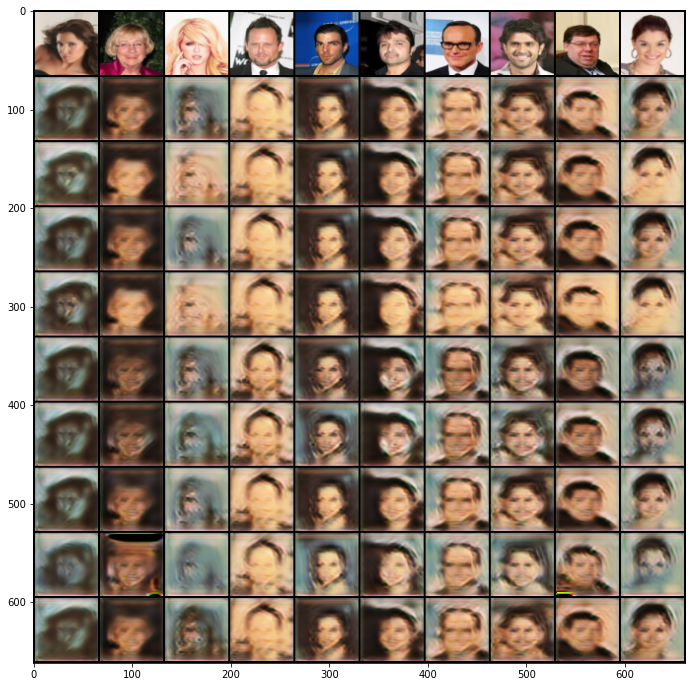

In [100]:
plt.figure(figsize=(16, 12))

plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
wandb.log({
    "5epochs_results/image": [wandb.Image(_o_im) for _o_im in orig_ims],
    "5epochs_results/G(image, same_labels)": [wandb.Image(_f_im) for _f_im in fake_ims]
})

In [101]:
wandb.finish()

## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета